In [1]:
!pip install datasets
!pip install transformers
!pip install bertopic
!sudo apt-get install swig
!sudo pip install jamspell
!wget https://github.com/bakwc/JamSpell-models/raw/master/en.tar.gz
!tar -xvf en.tar.gz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 9.4 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 39.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-whe

In [44]:
uberdf = pd.read_csv('./uberdf.csv')

In [7]:
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm import tqdm

import re

import jamspell

from transformers import AutoConfig
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DistilBertForSequenceClassification

from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer


import nltk
import string
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from collections import defaultdict
from collections import Counter

import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [8]:
# Removemos los tweets duplicados
uberDf = uberdf.drop_duplicates(subset='content')
len(uberdf)

72740

In [9]:
corrector = jamspell.TSpellCorrector()
corrector.LoadLangModel('en.bin')
punct = ''.join([i for i in string.punctuation if i not in [',','?','!','.']])

def light_clean(x):
  # Removemos las url.
  x = re.sub(r"http\S+", ' ', x)
  # Removemos las palabras que empiezan por @.
  x = re.sub(r'@[\w]+', '', x)
  # Signos de puntuacion menos. 
  x = x.translate(str.maketrans('', '', punct))
  x = x.replace('#', '')
  # Spell check
  x = corrector.FixFragment(x)
  return x

In [10]:
# Aplicamos la funcion de limpieza de datos.
uberDf['content'] = uberDf['content'].apply(str)

In [11]:
uberDf['corpus'] = [light_clean(i) for i in tqdm(uberDf['content'])]

100%|██████████| 70840/70840 [02:45<00:00, 428.84it/s]


In [12]:
uberDf['date'] = uberDf['date'].apply(str)

In [13]:
uberDf[['date', 'hour']] = uberDf.date.str.split(" ", expand=True)

In [14]:
# Modelo a utilizar
MODEL = f"siberett/roberta-sentiment-analysis-finetune"

In [15]:
 # Iniciamos el tokenizador
tokenizer = AutoTokenizer.from_pretrained(MODEL)

Downloading:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [16]:
 # Iniciamos el modelo.
model = AutoModelForSequenceClassification.from_pretrained(MODEL) 

Downloading:   0%|          | 0.00/964 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [17]:
import operator
from scipy.special import softmax

def polarity_predict(example):
  # vectorizamos el texto
  encoded_text = tokenizer(example, return_tensors='pt')
  # aplicamos el modelo
  output = model(**encoded_text)
  # Cogemos los scores de las labels
  scores = output[0][0].detach().numpy()
  # Normalizamos los scores
  scores = softmax(scores)
  # creamos un diccionario con las label y sus scores
  scores_dict = {
      '0' : scores[0],
      '1' : scores[1],
      '2' : scores[2]
  }
  # Obtenemos la label con mayor score
  final_label = max(scores_dict.items(), key=operator.itemgetter(1))[0]
  
  return final_label

In [18]:
uberDf['label'] = [polarity_predict(i) for i in tqdm(uberDf['corpus'])]

100%|██████████| 70840/70840 [1:39:20<00:00, 11.88it/s]


In [19]:
uberDf = uberDf.drop(uberDf[uberDf['date'] == '0'].index)
uberDf['date'] = pd.to_datetime(uberDf['date'], format="%Y-%m-%d")

In [36]:
counts = uberDf['label'].value_counts(normalize=True).reset_index()
counts.columns = ['target', 'ratio']

alt.Chart(counts).mark_bar().encode(
    x=alt.X('target:N', title='Categorías'),
    y=alt.Y('ratio:Q', scale=alt.Scale(domain=(0, 1)), title='Ratio sobre total'),
    tooltip=['target', 'ratio']
).properties(width=600, height=200)

alt.Chart(...)

In [71]:
counts

,target,ratio
0,1,0.430929
1,0,0.362112
2,2,0.206959


In [40]:
uberDf['label'].value_counts()

1    30527
0    25652
2    14661
Name: label, dtype: int64

Text(0, 0.5, '')

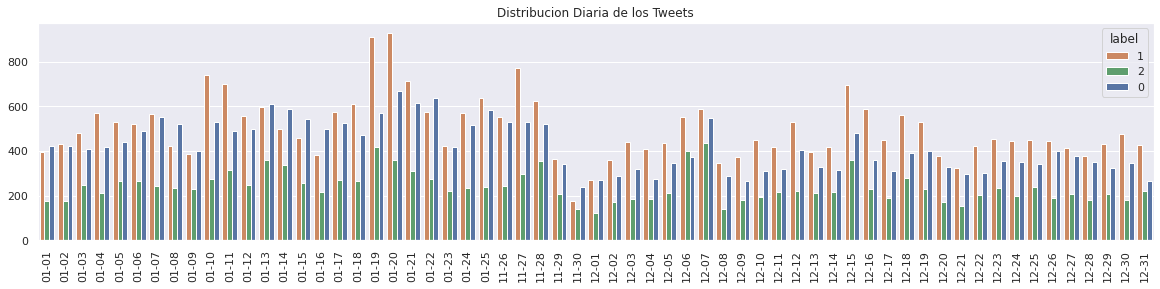

In [39]:
sns.set(rc={"figure.figsize":(20, 4)})
g = sns.countplot(data=uberDf.sort_values('date'), x="date", hue="label", palette=["C1", "C2", "C0"])
x_dates = uberDf['date'].dt.strftime('%m-%d').sort_values().unique()
g.set_xticklabels(x_dates)
g.tick_params(axis='x', rotation=90)

g.set_title('Distribucion Diaria de los Tweets')
g.set_xlabel('')
g.set_ylabel('')


In [47]:
print("indice de reputacion", (14661 - 25652) / (14661 + 25652))

indice de reputacion -0.2726415796393223
